In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from glob import glob

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
import pickle
import os
import NN

import dataset_utils
import importlib
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import LinearLocator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv3D, MaxPooling3D, Embedding, LSTM, Bidirectional, Reshape, Concatenate

In [9]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        all_train_points=[]
        for f in train_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                all_train_points.append(data)
                
                concatenated_train_points = np.concatenate(all_train_points, axis=0)
                sampled_indices = np.random.choice(concatenated_train_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_train_points[sampled_indices].astype(np.float16)
                train_points.append(sampled_data)
                train_labels.append(i)
               
        all_test_points = []
        for f in test_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                all_test_points.append(data)
                
                concatenated_test_points = np.concatenate(all_test_points, axis=0)
                sampled_indices = np.random.choice(concatenated_test_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_test_points[sampled_indices].astype(np.float16)
                test_points.append(sampled_data)
                test_labels.append(i)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [39]:
DATA_DIR = "cluster_data/3_class_data"
NUM_POINTS = 100
NUM_FRAMES = 3
NUM_CLASSES = 3
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = dataset_utils.parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: jumping


In [21]:
keras.utils.set_random_seed(seed=42)

In [22]:
print(train_points.shape)

(652, 100, 5)


In [23]:
def ConvBlock(x, filters, kernel_size=1, stride=1, padding='valid'):
    """Convolutional Block with Batch Normalization and ReLU activation."""
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

In [24]:

# Input layer for point cloud data

input_shape = (NUM_POINTS, 5)
num_classes = NUM_CLASSES
inputs = layers.Input(shape=input_shape)

# Expand dimensions for point-wise convolution
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(inputs)

# Convolutional Layers
x = ConvBlock(x, filters=64, kernel_size=(1, input_shape[1]))
x = ConvBlock(x, filters=128, kernel_size=(1, 1))
x = ConvBlock(x, filters=256, kernel_size=(1, 1))

# Global Feature Aggregation
x = layers.GlobalMaxPooling2D()(x)

# Fully connected layers for classification
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Output layer with softmax for classification
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Build model
model = models.Model(inputs=inputs, outputs=outputs)



In [25]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 5)]          0         
                                                                 
 lambda_1 (Lambda)           (None, 100, 5, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 1, 64)        384       
                                                                 
 batch_normalization_3 (Bat  (None, 100, 1, 64)        256       
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 100, 1, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 1, 128)       8320      
                                                                 
 batch_nor

In [36]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# training
history = model.fit(train_points, train_labels, epochs=30, validation_data=(test_points, test_labels), verbose=1, callbacks=[early_stopping])

Epoch 1/30
21/21 [==============================] - 0s 19ms/step - loss: 0.0145 - accuracy: 0.9954 - val_loss: 5.2237 - val_accuracy: 0.4207
Epoch 2/30
21/21 [==============================] - 0s 17ms/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.1044 - val_accuracy: 0.9756
Epoch 3/30
21/21 [==============================] - 0s 15ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.5375 - val_accuracy: 0.7195
Epoch 4/30
21/21 [==============================] - 0s 15ms/step - loss: 0.0036 - accuracy: 0.9985 - val_loss: 0.1617 - val_accuracy: 0.9512
Epoch 5/30
21/21 [==============================] - 0s 15ms/step - loss: 6.3724e-04 - accuracy: 1.0000 - val_loss: 0.9209 - val_accuracy: 0.8293


In [37]:
test_loss, test_acc = model.evaluate(test_points, test_labels, verbose=1)

6/6 [==============================] - 0s 7ms/step - loss: 0.9209 - accuracy: 0.8293


6/6 [==============================] - 0s 4ms/step


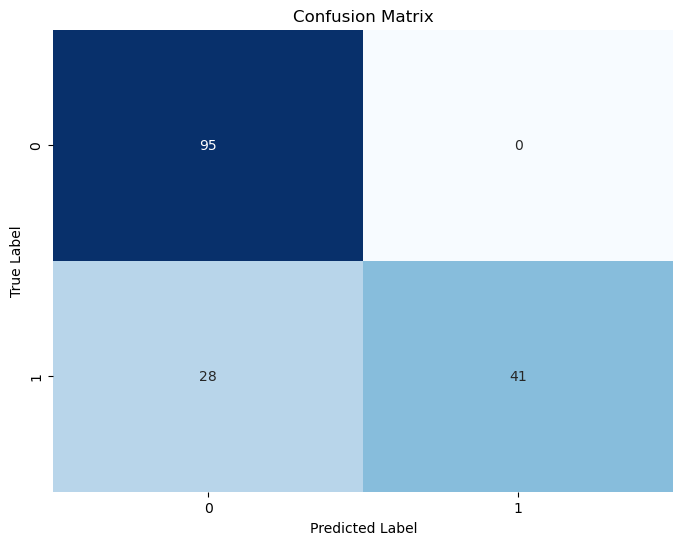

In [38]:
y_pred = np.argmax(model.predict(test_points), axis=1)

cm = tf.math.confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()